# Generating and Segmenting with Character-Level Transformer

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd

phoible = pd.read_csv('../data/phoible.csv')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_74273/1538564286.py:6: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../data/phoible.csv')


## Load corpus

In [2]:
from datasets import load_dataset
dataset = load_dataset('transformersegmentation/CHILDES', 'English')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'gloss', 'stem', 'type', 'language', 'num_morphemes', 'num_tokens', 'part_of_speech', 'speaker_role', 'target_child_age', 'target_child_sex', 'collection_id', 'corpus_id', 'speaker_id', 'target_child_id', 'transcript_id', 'is_child', 'processed_gloss', 'phonemized_utterance', 'language_code', 'character_split_utterance'],
        num_rows: 1636954
    })
    valid: Dataset({
        features: ['id', 'gloss', 'stem', 'type', 'language', 'num_morphemes', 'num_tokens', 'part_of_speech', 'speaker_role', 'target_child_age', 'target_child_sex', 'collection_id', 'corpus_id', 'speaker_id', 'target_child_id', 'transcript_id', 'is_child', 'processed_gloss', 'phonemized_utterance', 'language_code', 'character_split_utterance'],
        num_rows: 10000
    })
})

## Load model

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map


tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')
phoneme_map = create_phoneme_map(tokenizer, '../data/phoible.csv')
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True
model = GPT2LMHeadModel.from_pretrained('transformersegmentation/grid-search-gpt2_lm_head_model-model', revision='English-02611')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [4]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: h ɪ ɹ ð æ t s s ɛ l f UTT_BOUNDARY j uː h æ f t ə k ʌ m b æ k t ə ð ə k ɹ ɔː l ɚ t ə m ɑː m i UTT_BOUNDARY ɪ z ð æ t j ʊ ɹ p
1: h æ v h ɪ ɹ UTT_BOUNDARY j uː d oʊ n t w ɔ n t t ɑː p ɹ ɪ ŋ UTT_BOUNDARY aɪ m t ɹ aɪ ɪ ŋ t ə s ɪ t ɔ n j uː UTT_BOUNDARY d uː j uː l aɪ k t ə
2: h æ v ɐ b ʌ n i UTT_BOUNDARY w ʌ t s ð æ t UTT_BOUNDARY ð æ t s m ɑː m i d uː ɪ ŋ UTT_BOUNDARY ð ə t uː b æ d w ʊ d ə n t w ɔ n t t ə h


## Attention Visualisation

In [5]:
import matplotlib.pyplot as plt
import seaborn

Utterance:  ðɛɹz ʌ feɪs wɪð ɡlæsɪz 
Encoder Layer 1


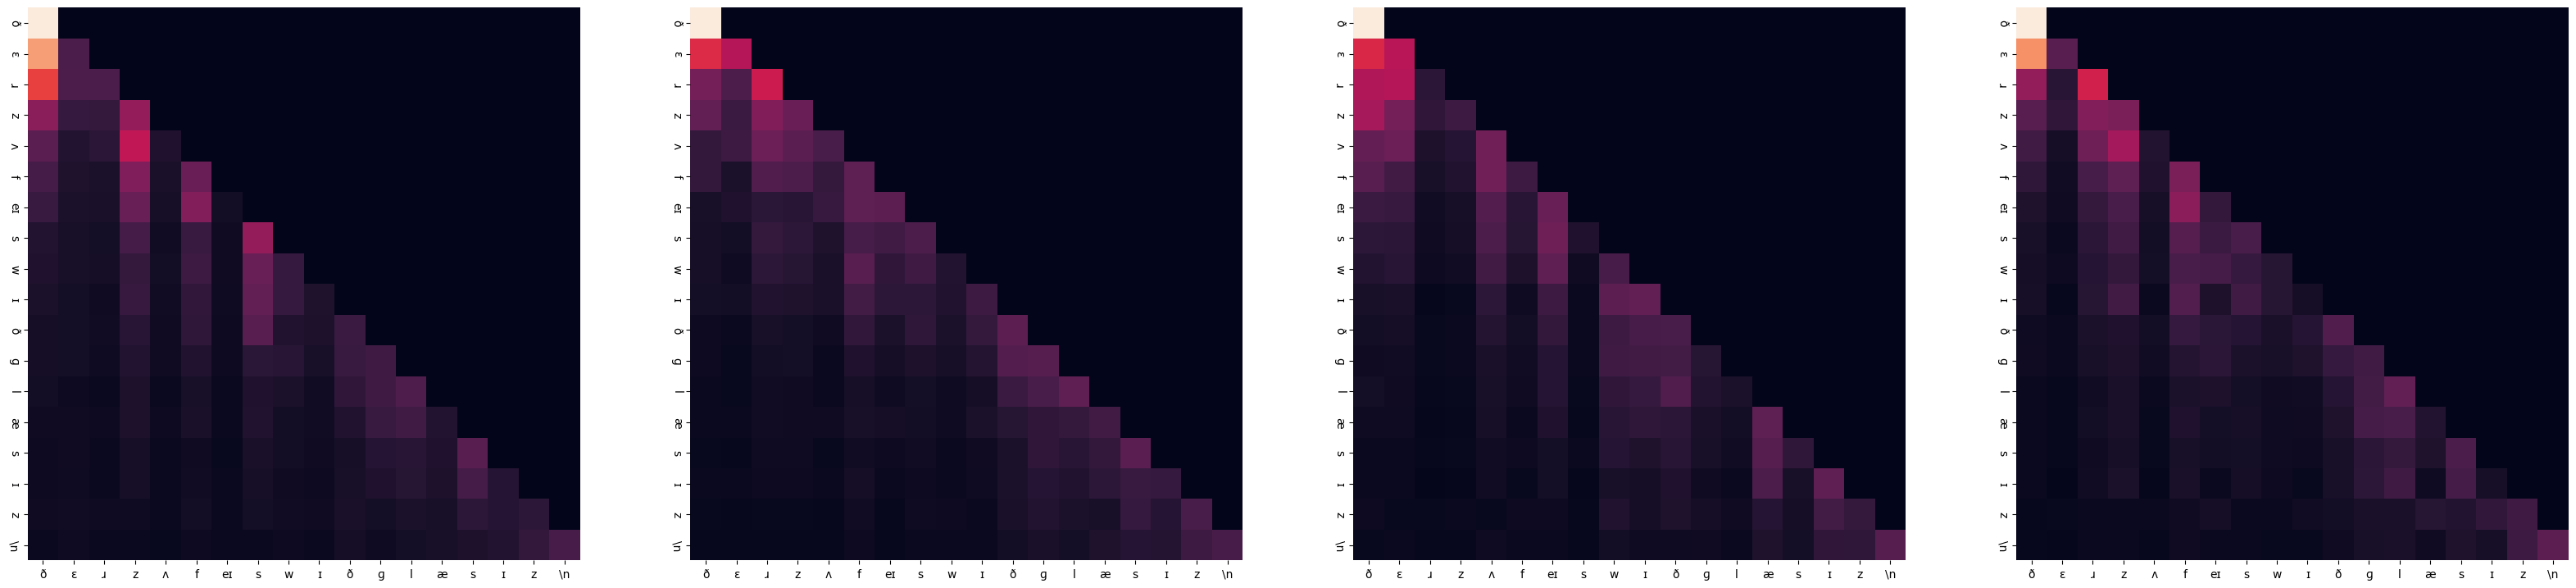

Encoder Layer 2


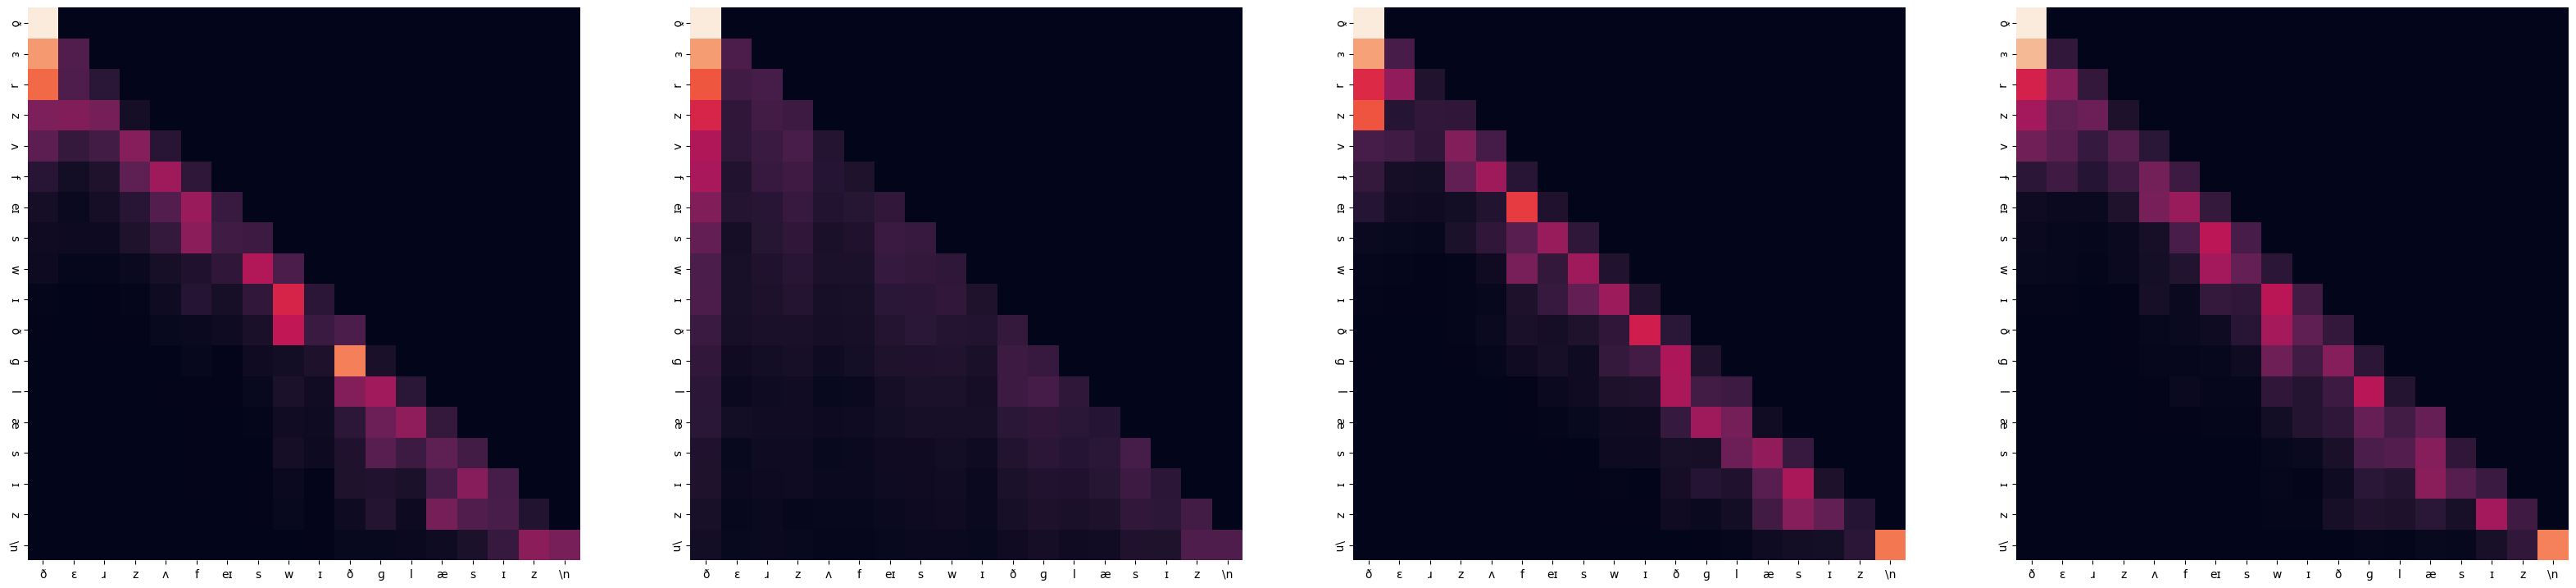

Encoder Layer 3


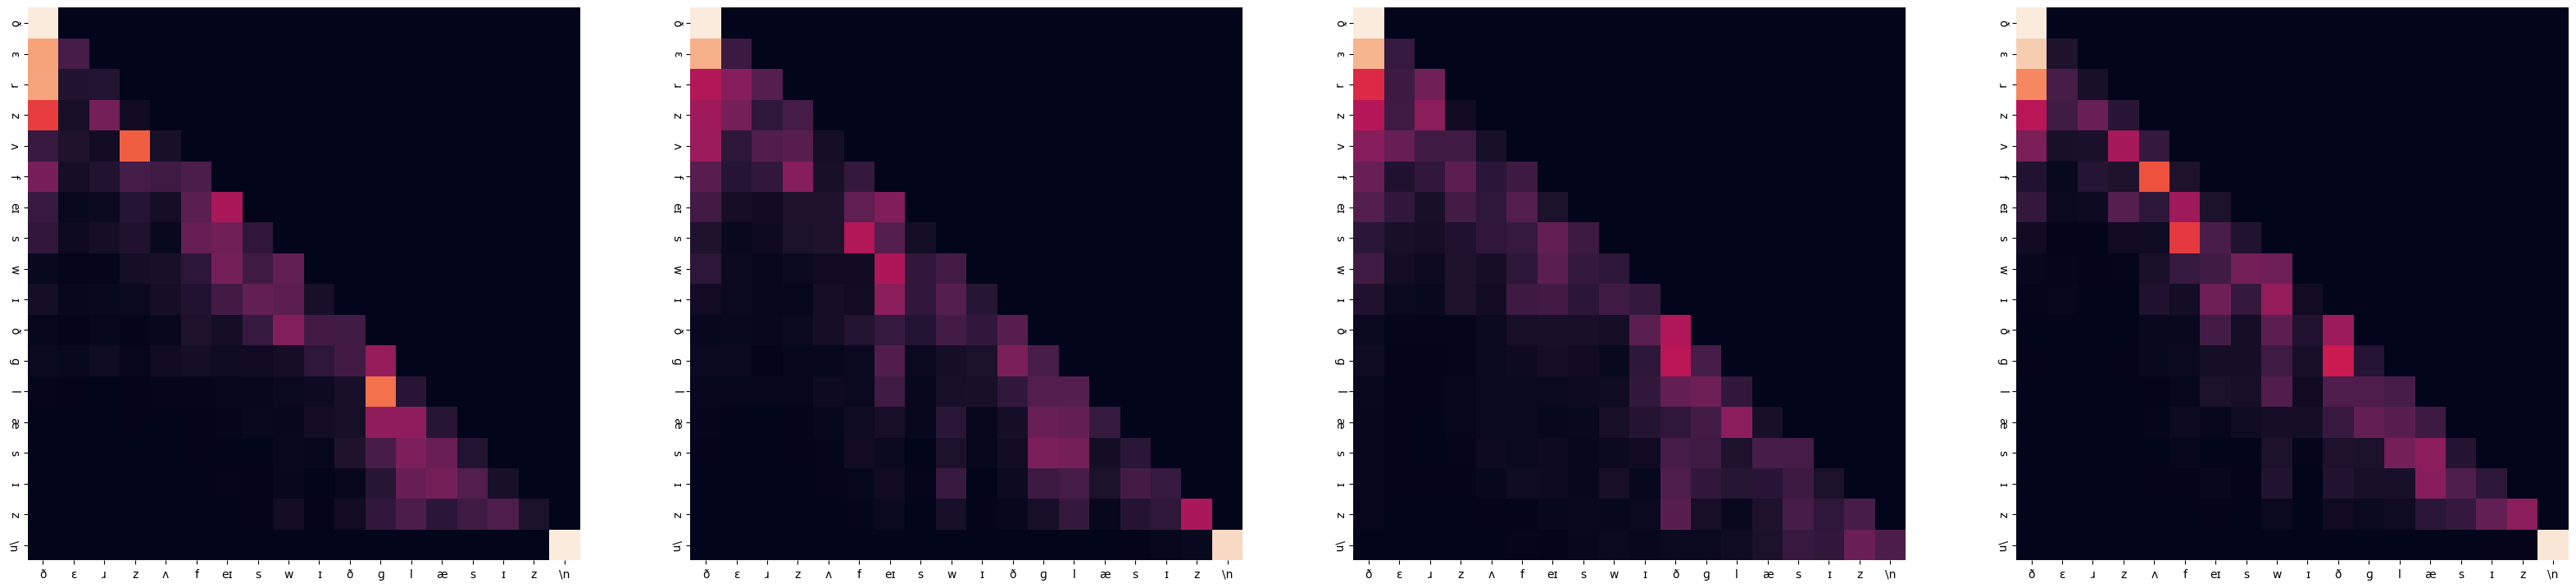

Encoder Layer 4


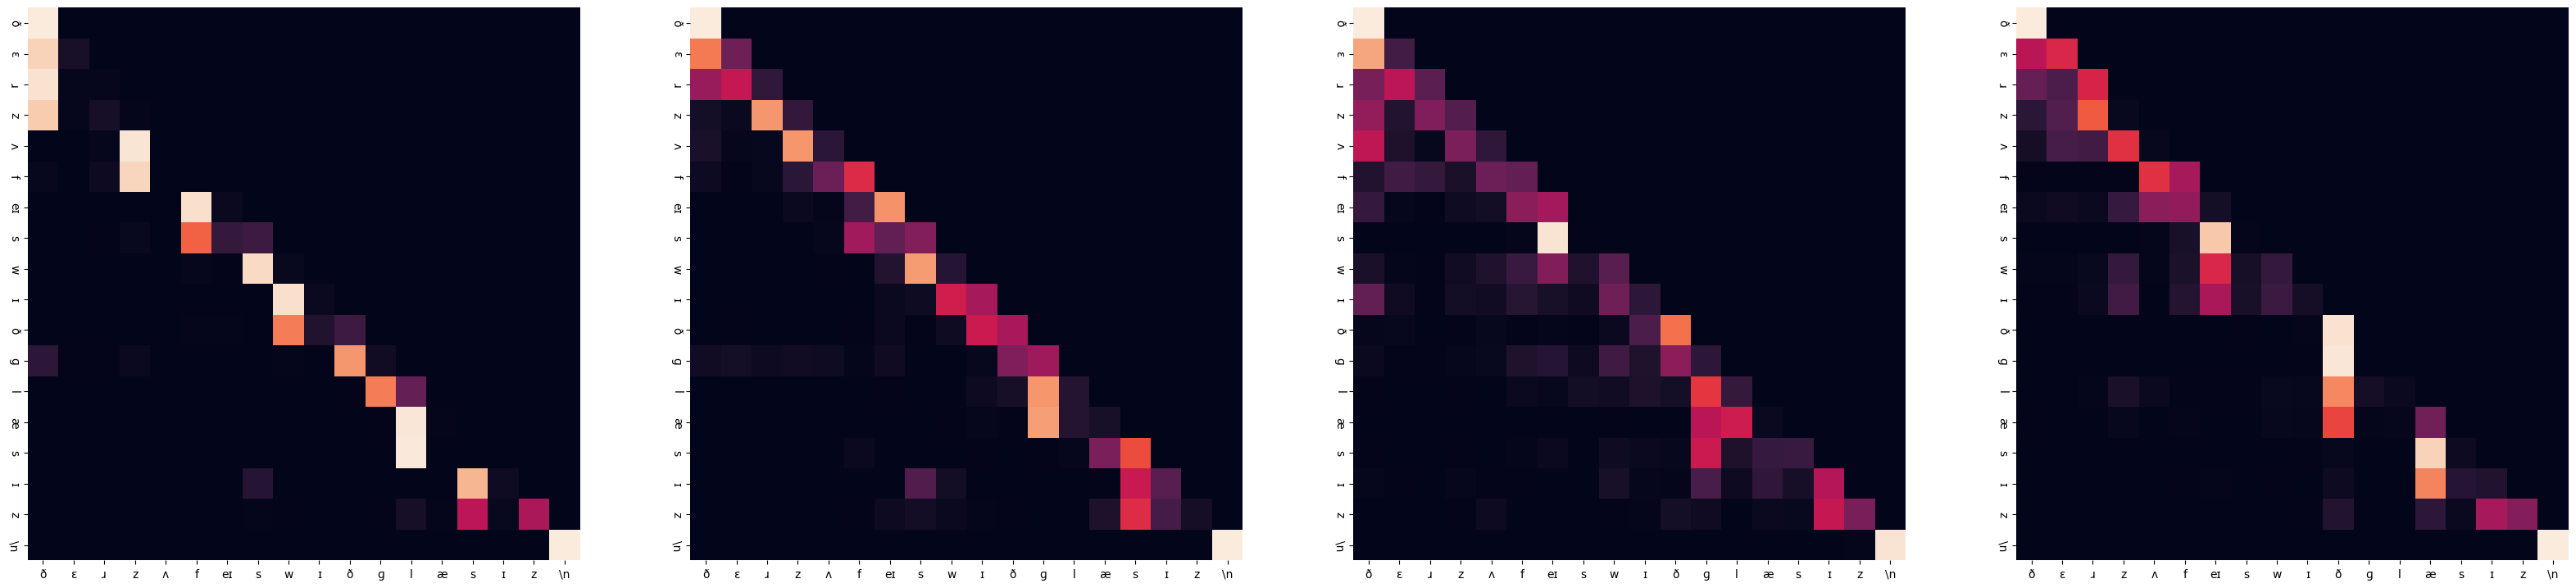

Encoder Layer 5


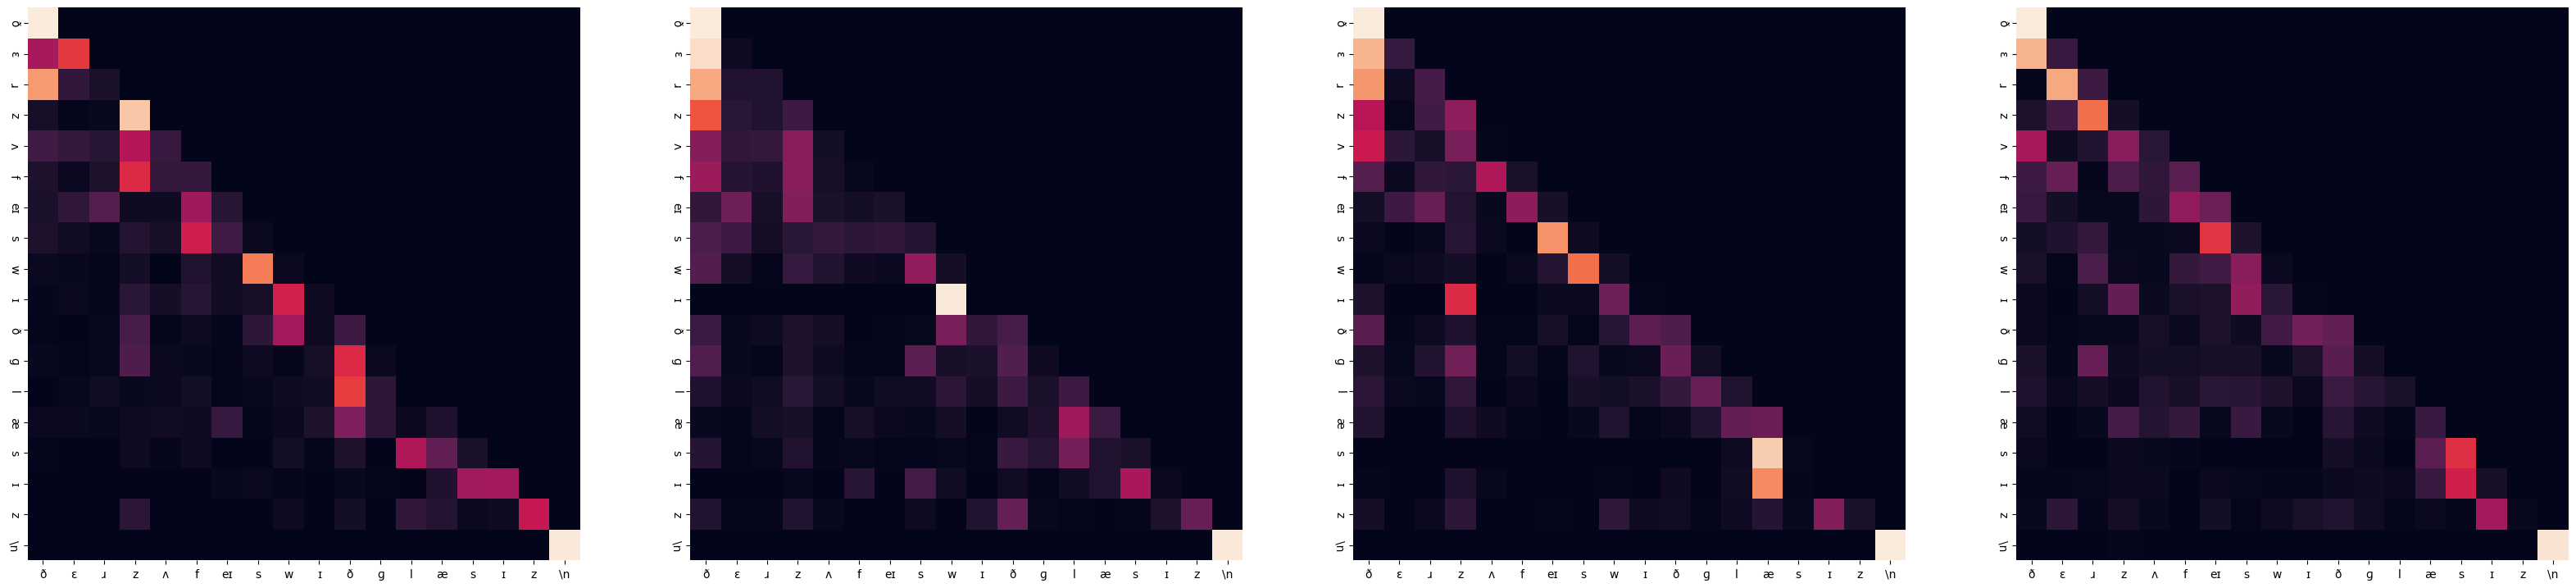

In [6]:
prompt = dataset['train']['phonemized_utterance'][1]
print("Utterance: ", prompt.replace(' ','').replace('WORD_BOUNDARY', ' '))
prompt = prompt.replace(' WORD_BOUNDARY', '')
prompt = prompt + ' UTT_BOUNDARY'

num_heads = model.config.n_head

def visualise_attention(prompt):
    input = tokenizer.encode(prompt, return_tensors='pt')
    prompt_text = tokenizer.convert_ids_to_tokens(input[0])
    prompt_text[-1] = '\\n'
    out = model.forward(input, labels=input, output_attentions=True, output_hidden_states=True, return_dict=True)
    attentions = [att.detach().numpy() for att in out.attentions]
    
    for layer in range(0, len(attentions), 1):
        fig, axs = plt.subplots(1,num_heads, figsize=(40, 20))
        print("Encoder Layer", layer+1)
        for h in range(num_heads):
            seaborn.heatmap(attentions[layer][:,h][0], 
                xticklabels=prompt_text, square=True, yticklabels=prompt_text, vmin=0, vmax=1,
                cbar=False, ax=axs[h])
            # Rotate x-axis labels by 90 degrees
            for item in axs[h].get_yticklabels():
                item.set_rotation(-90)
        plt.show()

visualise_attention(prompt)



In [7]:
english_phoneme_data = phoible#[phoible['LanguageName'].isin(['English (American)', 'American English'])]

# Get the input embedding layer for every phoneme
english_phonemes_count = {}
for utterance in list(dataset['train']['phonemized_utterance']):
    for pho in utterance.split():
        if pho in english_phonemes_count:
            english_phonemes_count[pho] += 1
        else:
            english_phonemes_count[pho] = 1
# Only include phonemes that appear more than 100 times
english_phonemes = [pho for pho in english_phonemes_count.keys() if english_phonemes_count[pho] > 100]
# Remove any tokens not in tokenizer or english phoneme data
english_phonemes = [pho for pho in english_phonemes if pho in tokenizer.get_vocab() and pho in english_phoneme_data.Phoneme.unique()]
print(english_phonemes)

['s', 'iː', 'ð', 'ɛ', 'ɹ', 'z', 'ʌ', 'f', 'eɪ', 'w', 'ɪ', 'ɡ', 'l', 'æ', 'ɑ', 'h', 'ə', 'ʊ', 'k', 'p', 'uː', 'b', 'i', 't', 'aɪ', 'θ', 'ŋ', 'j', 'ɔ', 'm', 'ɔɪ', 'n', 'd', 'oʊ', 'aʊ', 'v', 'ɜː', 't̠ʃ', 'd̠ʒ', 'ʃ', 'ʒ']


In [8]:
# Get embeddings
input_embeddings = np.zeros((len(english_phonemes), model.config.n_embd))
for i, pho in enumerate(english_phonemes):
    input_ids = tokenizer.encode(pho, return_tensors='pt')
    out = model.forward(input_ids, output_hidden_states=True, return_dict=True)
    input_embeddings[i] = out.hidden_states[0].detach().numpy()

# Project embeddings to 2D
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10)
X_embedded = tsne.fit_transform(input_embeddings)

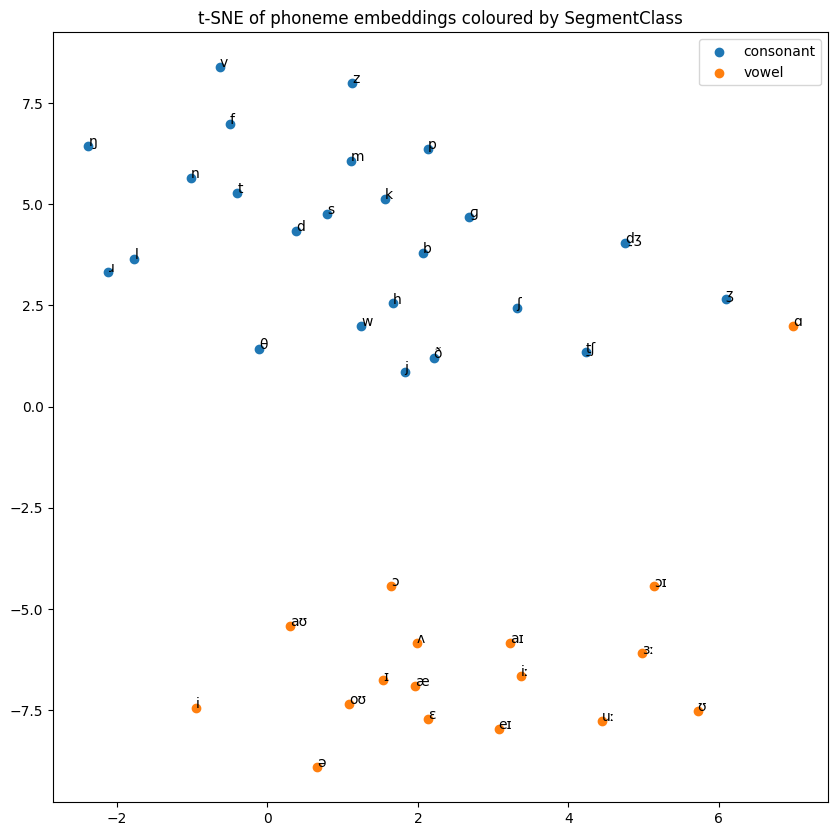

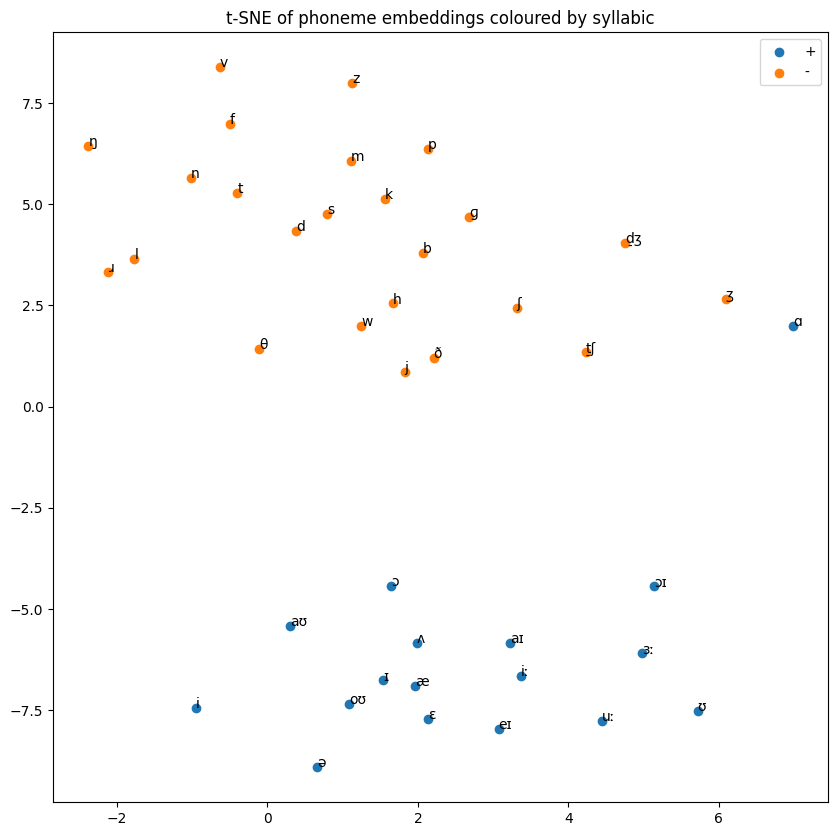

In [9]:
# Plot embeddings with phoneme labels

all_possible_features = ["syllabic", "tone","stress","short","long","consonantal","sonorant","continuant","delayedRelease","approximant","tap","trill","nasal","lateral","labial","round","labiodental","coronal","anterior","distributed","strident","dorsal","high","low","front","back","tense","retractedTongueRoot","advancedTongueRoot","periodicGlottalSource","epilaryngealSource","spreadGlottis","constrictedGlottis","fortis","lenis","raisedLarynxEjective","loweredLarynxImplosive","click"]

def plot_phoneme_embeddings(embeddings, phonemes, features):
    for feature in features:
        feature_map = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho][feature].values[0] for pho in phonemes]

        plt.figure(figsize=(10, 10))
        for i, value in enumerate(np.unique(feature_map)):
            indices = [j for j, val in enumerate(feature_map) if val == value]
            plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=value)
            for j in indices:
                plt.annotate(phonemes[j], (embeddings[j, 0], embeddings[j, 1]))
        plt.title(f"t-SNE of phoneme embeddings coloured by {feature}")
        plt.legend()
        plt.show()

features = ['SegmentClass', 'syllabic']
plot_phoneme_embeddings(X_embedded, english_phonemes, features)


['iː', 'ɛ', 'ʌ', 'eɪ', 'ɪ', 'æ', 'ɑ', 'ə', 'ʊ', 'uː', 'i', 'aɪ', 'ɔ', 'ɔɪ', 'oʊ', 'aʊ', 'ɜː']
(17, 128)
['s', 'ð', 'ɹ', 'z', 'f', 'w', 'ɡ', 'l', 'h', 'k', 'p', 'b', 't', 'θ', 'ŋ', 'j', 'm', 'n', 'd', 'v', 't̠ʃ', 'd̠ʒ', 'ʃ', 'ʒ']


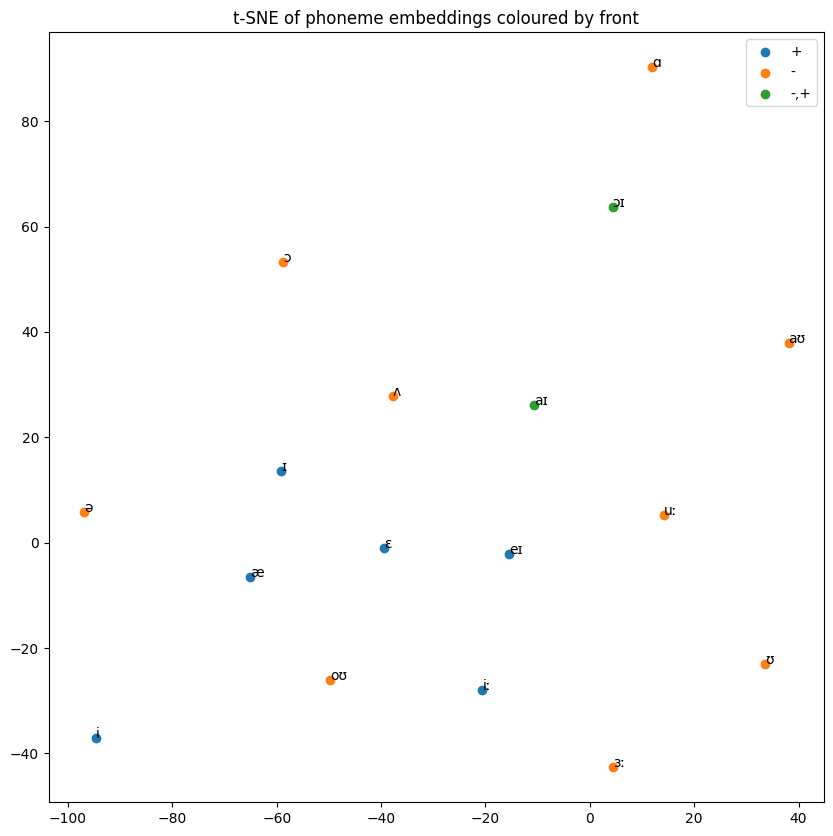

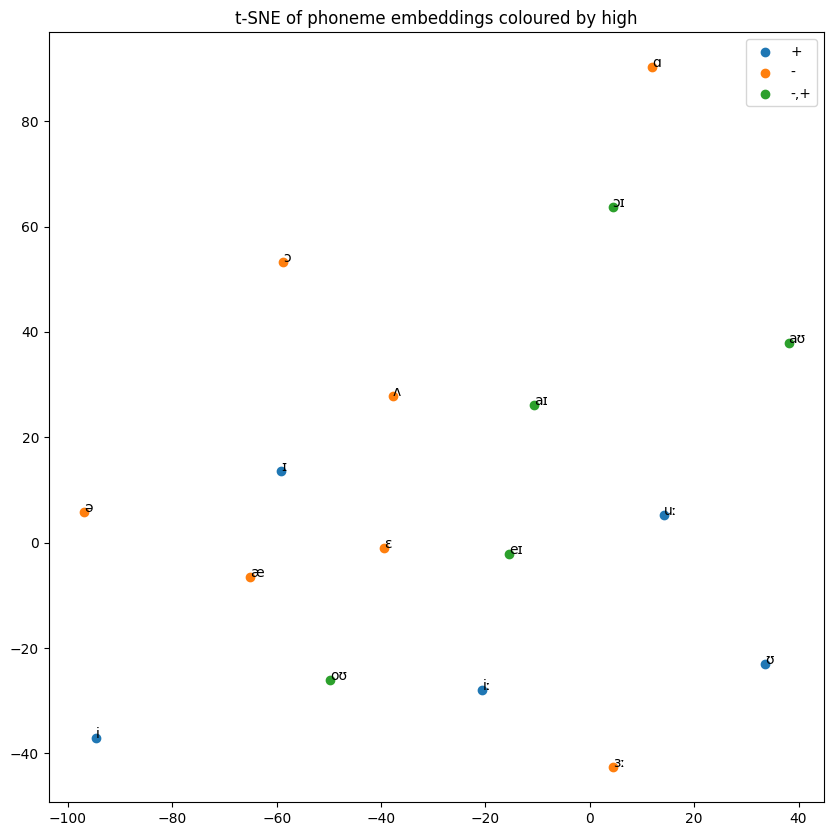

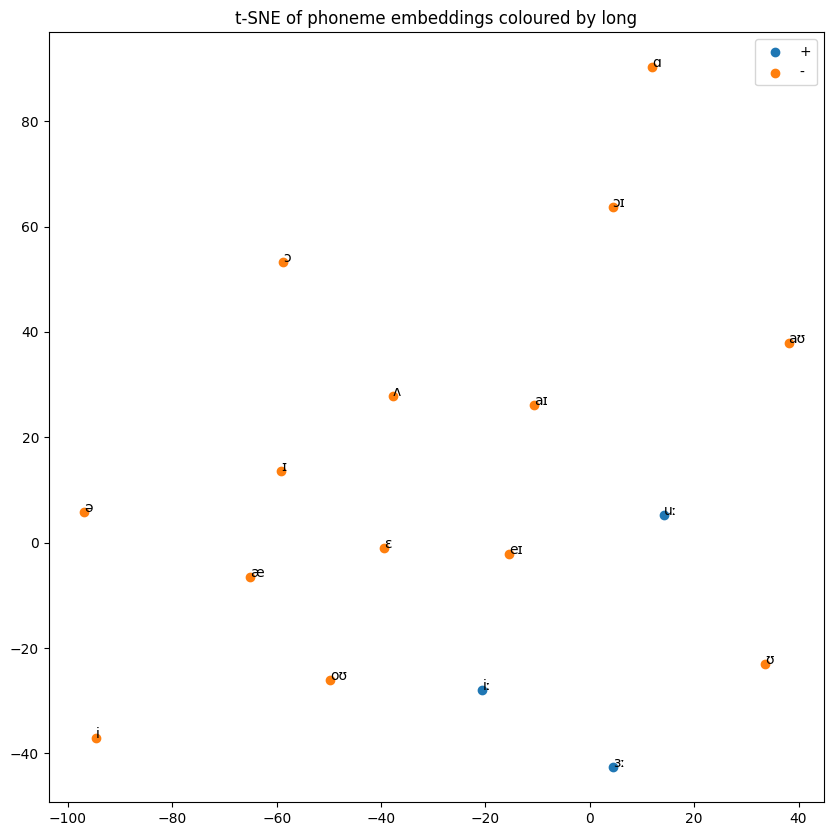

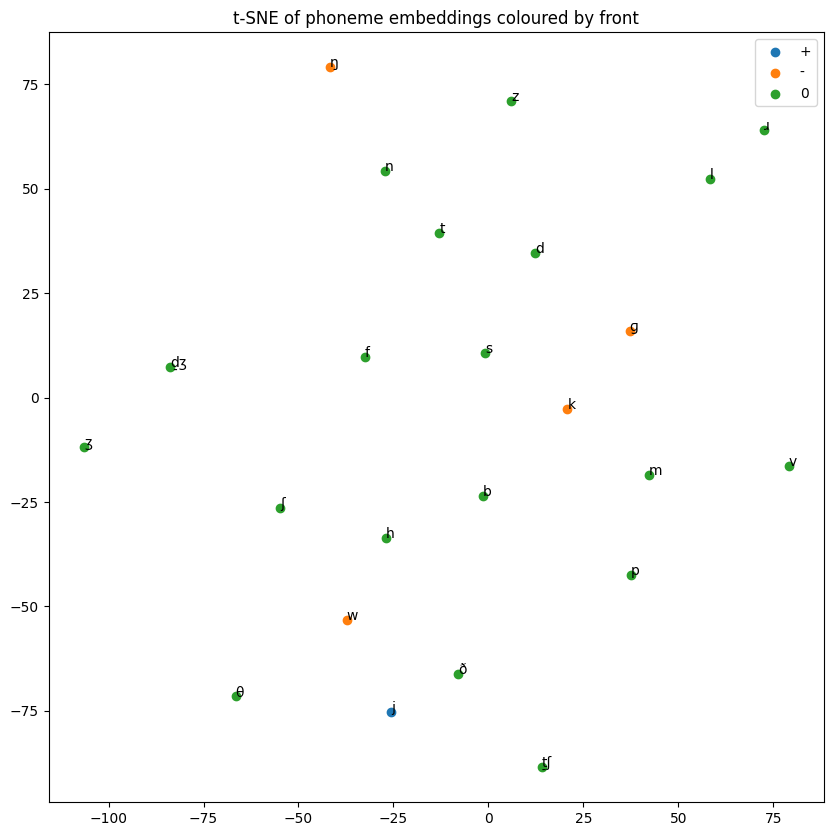

In [10]:
# Do TSNE again but just vowels
vowels = [pho for pho in english_phonemes if english_phoneme_data[english_phoneme_data['Phoneme'] == pho]['SegmentClass'].values[0] == 'vowel']
vowel_embeddings = [input_embeddings[english_phonemes.index(pho)] for pho in vowels]
print(vowels)
vowel_embeddings = np.array(vowel_embeddings)
print(vowel_embeddings.shape)
vowel_phonemes = vowels
tsne = TSNE(n_components=2, perplexity=8)
X_embedded_vowels = tsne.fit_transform(vowel_embeddings)

# Do TSNE again but just consonants
consonants = [pho for pho in english_phonemes if english_phoneme_data[english_phoneme_data['Phoneme'] == pho]['SegmentClass'].values[0] == 'consonant']
consonant_embeddings = [input_embeddings[english_phonemes.index(pho)] for pho in consonants]
consonant_embeddings = np.array(consonant_embeddings)
consonant_phonemes = consonants
print(consonants)
X_embedded_consonants = tsne.fit_transform(consonant_embeddings)


plot_phoneme_embeddings(X_embedded_vowels, vowel_phonemes, ['front', 'high', 'long'])
plot_phoneme_embeddings(X_embedded_consonants, consonant_phonemes, ['front'])

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


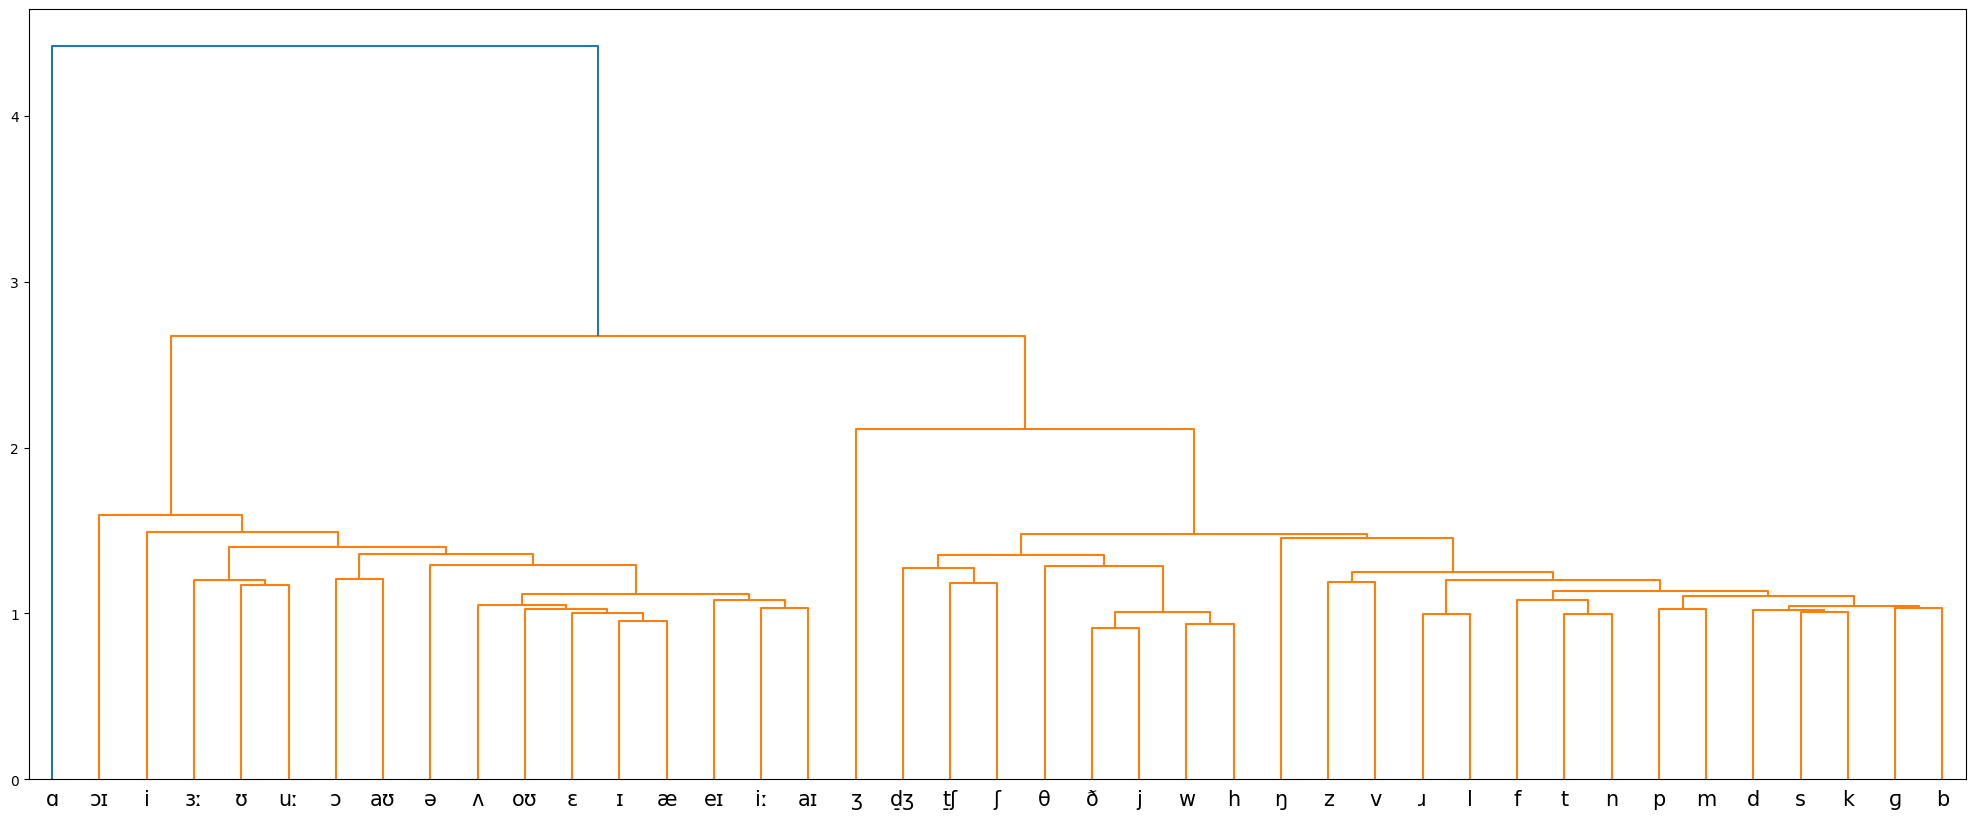

In [11]:
# plot cluster tree
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

kmeans = KMeans(n_clusters=5)
kmeans.fit(input_embeddings)
labels = kmeans.labels_

def plot_dendogram(embeddings, phonemes):
    dist = pdist(embeddings)
    Z = linkage(dist, 'ward')
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels=phonemes)
    plt.xticks(rotation=0)
    plt.tick_params(axis='x', which='major', labelsize=15)
    plt.show()

plot_dendogram(input_embeddings, english_phonemes)


plt.show()



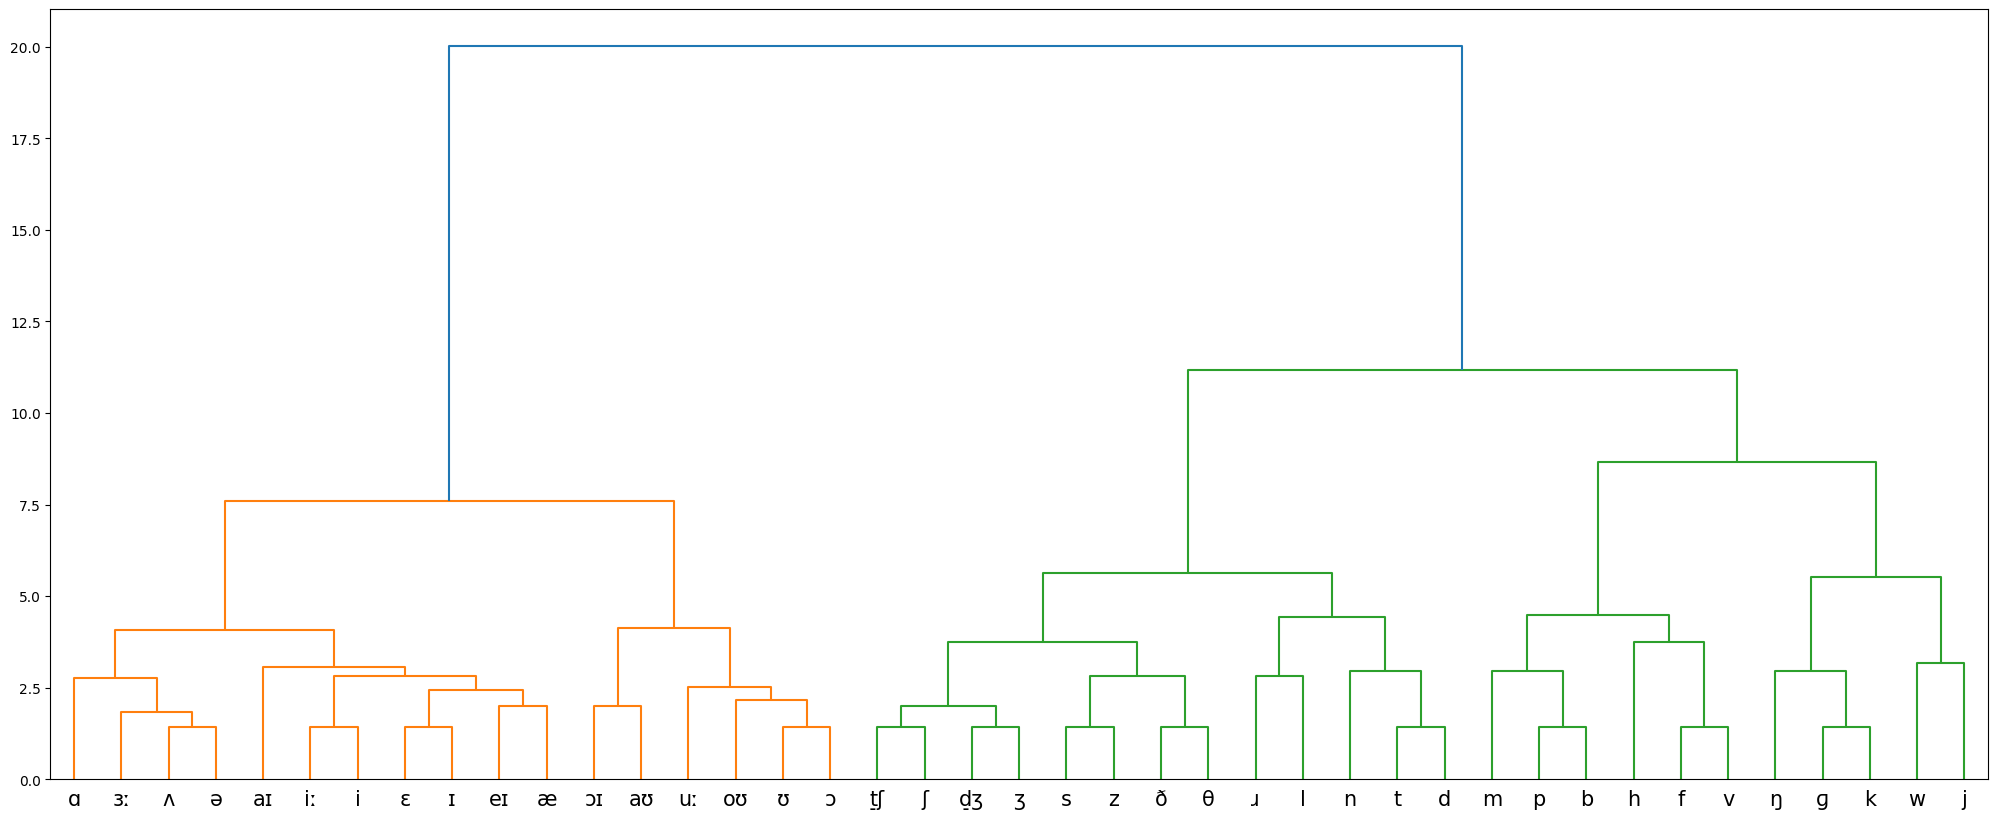

In [12]:
phoneme_map_vectors = []
for phoneme in english_phonemes:
    token_id = tokenizer.encode(phoneme, return_tensors='pt')
    phoneme_features = phoneme_map[token_id[0].item()]
    vec = []
    for f in phoneme_features:
        if f == 0:
            vec += [0,0,1]
        elif f == 1:
            vec += [0,1,0]
        elif f == 2:
            vec += [1,0,0]
    phoneme_map_vectors.append(vec)
phoneme_map_vectors

plot_dendogram(phoneme_map_vectors, english_phonemes)

In [13]:
def difference_between_two_phoneme(phoneme_1, phoneme_2):
    # Use phoible to find the features that differ between the two phonemes
    phoneme_1_features = english_phoneme_data[english_phoneme_data['Phoneme'] == phoneme_1].iloc[0]
    phoneme_2_features = english_phoneme_data[english_phoneme_data['Phoneme'] == phoneme_2].iloc[0]
    diff = []
    for feature in all_possible_features:
        if phoneme_1_features[feature] != phoneme_2_features[feature]:
            diff.append(feature)
    return diff

def difference_between_two_phoneme_sets(phonemes_1, phonemes_2):
    # Use phoible to find the features that differ between the two phonemes sets.
    # First find all features in common within two sets, then find the features that differ
    phoneme_1_features = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho].iloc[0] for pho in phonemes_1]
    phoneme_2_features = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho].iloc[0] for pho in phonemes_2]
    common_features_1 = {}
    common_features_2 = {}
    for feature in all_possible_features:
        features_1 = [pho[feature] for pho in phoneme_1_features]
        features_2 = [pho[feature] for pho in phoneme_2_features]
        if all([f == features_1[0] for f in features_1]) and all([f == features_2[0] for f in features_2]):
            common_features_1[feature] = features_1[0]
            common_features_2[feature] = features_2[0]
    diff = []
    print(common_features_1)
    print(common_features_2)
    for feature in common_features_1.keys():
        if common_features_1[feature] != common_features_2[feature]:
            diff.append(feature + ' ' + str(common_features_1[feature]) + ' ' + str(common_features_2[feature]))
    return diff

print(difference_between_two_phoneme_sets(['m'], ['n']))
print(difference_between_two_phoneme_sets(['f','v','m','p','b'],['h','ʔ']))
print(difference_between_two_phoneme_sets(['f','v','m','p','b','h','ʔ'],['ɡ','k','w','j','ŋ']))


print(difference_between_two_phoneme_sets(['i','aɪ','iː','ɛ','ɪ','eɪ','æ'],['ɚ','ɑː','ɜː','ə','ʌ']))
print(difference_between_two_phoneme_sets(['ɐ', 'ʊ', 'uː', 'oː', 'ɔɪ', 'oʊ', 'ɔ', 'aʊ', 'ɔː'],['i','aɪ','iː','ɛ','ɪ','eɪ','æ','ɚ','ɑː','ɜː','ə','ʌ']))
print(difference_between_two_phoneme_sets(['ɔɪ','aʊ'],['ɐ','ʊ', 'uː', 'oː', 'oʊ', 'ɔ', 'ɔː']))
print(difference_between_two_phoneme_sets(['ʊ'],['ɔ']))


{'syllabic': '-', 'tone': '0', 'stress': '-', 'short': '-', 'long': '-', 'consonantal': '+', 'sonorant': '+', 'continuant': '-', 'delayedRelease': '0', 'approximant': '-', 'tap': '-', 'trill': '-', 'nasal': '+', 'lateral': '-', 'labial': '+', 'round': '-', 'labiodental': '-', 'coronal': '-', 'anterior': '0', 'distributed': '0', 'strident': '0', 'dorsal': '-', 'high': '0', 'low': '0', 'front': '0', 'back': '0', 'tense': '0', 'retractedTongueRoot': '-', 'advancedTongueRoot': '-', 'periodicGlottalSource': '+', 'epilaryngealSource': '-', 'spreadGlottis': '-', 'constrictedGlottis': '-', 'fortis': '-', 'lenis': '-', 'raisedLarynxEjective': '-', 'loweredLarynxImplosive': '-', 'click': '-'}
{'syllabic': '-', 'tone': '0', 'stress': '-', 'short': '-', 'long': '-', 'consonantal': '+', 'sonorant': '+', 'continuant': '-', 'delayedRelease': '0', 'approximant': '-', 'tap': '-', 'trill': '-', 'nasal': '+', 'lateral': '-', 'labial': '-', 'round': '0', 'labiodental': '0', 'coronal': '+', 'anterior': '+'

In [14]:
print(vowels)

['iː', 'ɛ', 'ʌ', 'eɪ', 'ɪ', 'æ', 'ɑ', 'ə', 'ʊ', 'uː', 'i', 'aɪ', 'ɔ', 'ɔɪ', 'oʊ', 'aʊ', 'ɜː']
